# Preprocessing

In [1]:
# Import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import recmetrics


Let's read the data into a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) so that we can begin to understand it.

*Note, we'll set `error_bad_lines=False` when reading the file in as there appear to be a very small number of records which would create a problem otherwise.*

In [2]:
data_folder = 'data/jester_ds4'
df = pd.read_excel(
    f'{data_folder}/interactions.xlsx', 
    index_col=0,
    header=None,
)
df.head()

,1,2,3,4,5,6,7,8,9,10,...,149,150,151,152,153,154,155,156,157,158
0,,,,,,,,,,,,,,,,,,,,,
1,99,99,99,99,99,99,99.0,99.0,99,99,...,99.0,99.0,99.00,99.00,99.0,99.0,99.0,99.0,99.00,99.00
1,99,99,99,99,99,99,99.0,99.0,99,99,...,99.0,99.0,99.00,99.00,99.0,99.0,99.0,99.0,99.00,99.00
4,99,99,99,99,99,99,99.0,99.0,99,99,...,99.0,99.0,99.00,99.00,99.0,99.0,99.0,99.0,99.00,99.00
47,99,99,99,99,99,99,99.0,99.0,99,99,...,99.0,99.0,5.61,-4.51,0.0,0.0,99.0,0.0,5.93,4.19
13,99,99,99,99,99,99,99.0,99.0,99,99,...,99.0,99.0,99.00,99.00,99.0,0.0,99.0,99.0,99.00,0.00


In [3]:
df.index.rename('user_id', inplace=True)
df_tmp = df.stack()
df_tmp.index.rename(['user_id', 'item_id'], inplace=True)
df_tmp = df_tmp.rename('rating')
df = df_tmp.reset_index(['user_id', 'item_id'])
df

,user_id,item_id,rating
0,1,1,99.0
1,1,2,99.0
2,1,3,99.0
3,1,4,99.0
4,1,5,99.0
...,...,...,...
1216437,2,154,99.0
1216438,2,155,99.0
1216439,2,156,99.0
1216440,2,157,99.0


In [4]:
df = df.rename(columns={'user_id':'USER_ID', 'item_id':'ITEM_ID', 'rating':'RATING'})
df

,USER_ID,ITEM_ID,RATING
0,1,1,99.0
1,1,2,99.0
2,1,3,99.0
3,1,4,99.0
4,1,5,99.0
...,...,...,...
1216437,2,154,99.0
1216438,2,155,99.0
1216439,2,156,99.0
1216440,2,157,99.0


In [5]:
df.to_csv(f"{data_folder}/interactions.csv.gz", header=True, index=False)

In [6]:
df = df.drop(df[df['RATING']==99].index)
df = df.drop(df[df['RATING']>10].index)
df = df.drop(df[df['RATING']<-10].index)
df

,USER_ID,ITEM_ID,RATING
71,1,72,3.70
229,1,72,8.21
334,4,19,-5.98
350,4,35,-4.47
387,4,72,1.59
...,...,...,...
1216281,64,156,0.57
1216282,64,157,0.00
1216283,64,158,0.00
1216302,2,19,4.59


In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 5))
df_scaled = scaler.fit_transform(df['RATING'].values.reshape(-1,1))
df['RATING'] = df_scaled
df

,USER_ID,ITEM_ID,RATING
71,1,72,3.4250
229,1,72,4.5525
334,4,19,1.0050
350,4,35,1.3825
387,4,72,2.8975
...,...,...,...
1216281,64,156,2.6425
1216282,64,157,2.5000
1216283,64,158,2.5000
1216302,2,19,3.6475


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


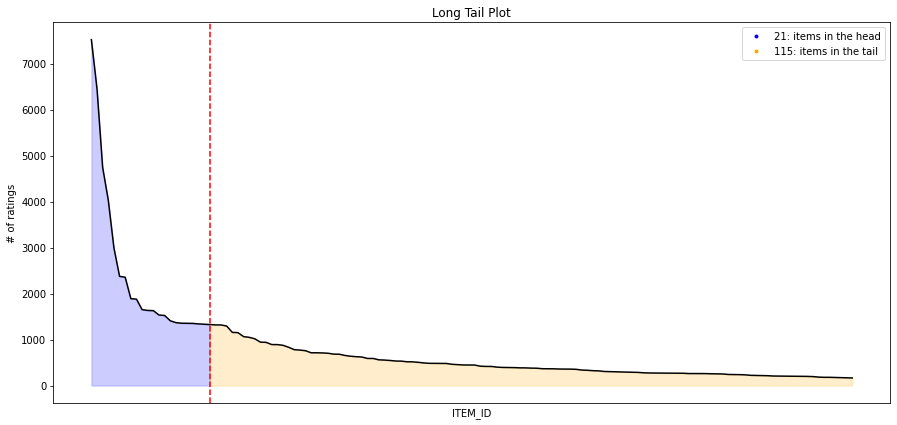

In [8]:
fig = plt.figure(figsize=(15, 7))
recmetrics.long_tail_plot(df=df, 
             item_id_column="ITEM_ID", 
             interaction_type="ratings", 
             percentage=0.5,
             x_labels=False)


In [18]:
quantiles = [0, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 1]
users = df['USER_ID'].value_counts()
items = df['ITEM_ID'].value_counts()

In [19]:
qntl = users.quantile(quantiles)
qntl


0.00     129.00
0.01     214.19
0.02     224.90
0.05     239.15
0.10     306.70
0.20     455.00
0.30     554.70
0.40     606.20
0.50     704.00
0.60     761.60
0.70     926.70
0.80    1148.40
0.90    1461.40
0.95    1778.60
0.98    2192.08
0.99    2264.22
1.00    2433.00
Name: USER_ID, dtype: float64

In [20]:
df_qntl = qntl.to_frame()
df_qntl.index.rename('Percent', inplace=True)
df_qntl['Percent'] = df_qntl.index

import altair as alt
import pandas as pd

alt.Chart(df_qntl).mark_line().encode(
    x=alt.X(
        "Percent:Q",
        axis=alt.Axis(
            tickCount=df_qntl.shape[0],
            grid=False,
            labelExpr="datum.value % 1 ? null : datum.label",
        )
    ),
    y='USER_ID'
)

alt.Chart(...)

In [21]:
qntl = items.quantile(quantiles)
qntl


0.00     166.00
0.01     173.35
0.02     176.10
0.05     193.25
0.10     207.50
0.20     261.00
0.30     295.50
0.40     366.00
0.50     447.50
0.60     534.00
0.70     711.50
0.80    1065.00
0.90    1466.50
0.95    2006.25
0.98    4243.60
0.99    5852.20
1.00    7519.00
Name: ITEM_ID, dtype: float64

In [22]:
df_qntl = qntl.to_frame()
df_qntl.index.rename('Percent', inplace=True)
df_qntl['Percent'] = df_qntl.index

import altair as alt
import pandas as pd

alt.Chart(df_qntl).mark_line().encode(
    x=alt.X(
        "Percent:Q",
        axis=alt.Axis(
            tickCount=df_qntl.shape[0],
            grid=False,
            labelExpr="datum.value % 1 ? null : datum.label",
        )
    ),
    y='ITEM_ID'
)

alt.Chart(...)

As we can see, only about x% of users have rated y or more items, and only u% of items have been rated by v users.

### Clean

Let's filter out this long tail.

In [83]:
users = users[users >= 0]
items = items[items >= 0]

df_reduced = df.merge(pd.DataFrame({'USER_ID': users.index})).merge(pd.DataFrame({'ITEM_ID': items.index}))
df_reduced

,USER_ID,ITEM_ID,RATING
0,1,72,3.4250
1,1,72,4.5525
2,1,72,2.8100
3,1,72,2.8850
4,1,72,2.9375
...,...,...,...
105943,117,141,2.5000
105944,114,141,2.5000
105945,114,141,2.5000
105946,101,141,2.5000


Now, we'll recreate our customer and product lists since there are customers with more than 5 reviews, but all of their reviews are on products with less than 5 reviews (and vice versa).

In [84]:
users = df_reduced['USER_ID'].value_counts()
items = df_reduced['ITEM_ID'].value_counts()


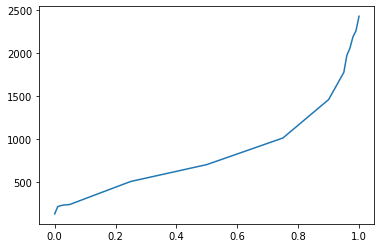

In [85]:
plt.plot(users.quantile(quantiles))

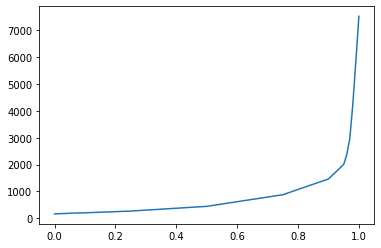

In [86]:
plt.plot(items.quantile(quantiles))

Next, we'll number each user and item, giving them their own sequential index.  This will allow us to hold the information in a sparse format where the sequential indices indicate the row and column in our ratings matrix.

In [87]:
user_index = pd.DataFrame({'USER_ID': users.index, 'user_idx': np.arange(users.shape[0])})
item_index = pd.DataFrame({'ITEM_ID': items.index, 
                              'item_idx': np.arange(items.shape[0])})

df_reduced = df_reduced.merge(user_index).merge(item_index)
df_reduced.head()


,USER_ID,ITEM_ID,RATING,user_idx,item_idx
0,1,72,3.4250,22,1
1,1,72,4.5525,22,1
2,1,72,2.8100,22,1
3,1,72,2.8850,22,1
4,1,72,2.9375,22,1


### Prepare

Let's start by splitting in training and test sets.  This will allow us to estimate the model's accuracy on videos our customers rated, but wasn't included in our training.

In [89]:
df_test = df_reduced.groupby('USER_ID').last().reset_index()

df_train = df_reduced.merge(df_test[['USER_ID', 'ITEM_ID']], 
                            on=['USER_ID', 'ITEM_ID'], 
                            how='outer', 
                            indicator=True)
df_train = df_train[(df_train['_merge'] == 'left_only')]

In [90]:
df_test

,USER_ID,ITEM_ID,RATING,user_idx,item_idx
0,1,94,2.0650,22,52
1,2,143,2.6625,4,80
2,3,104,3.2475,2,10
3,4,102,0.1625,0,83
4,5,8,1.8650,1,61
...,...,...,...,...,...
125,126,141,0.0000,99,135
126,127,141,2.5000,97,135
127,129,141,2.5000,129,135
128,130,141,2.5000,121,135


In [91]:
df_train

,USER_ID,ITEM_ID,RATING,user_idx,item_idx,_merge
0,1,72,3.4250,22,1,left_only
1,1,72,4.5525,22,1,left_only
2,1,72,2.8100,22,1,left_only
3,1,72,2.8850,22,1,left_only
4,1,72,2.9375,22,1,left_only
...,...,...,...,...,...,...
105777,117,124,2.5000,125,131,left_only
105778,114,124,2.5000,88,131,left_only
105779,114,124,1.8100,88,131,left_only
105780,114,124,0.4475,88,131,left_only


Now, we can convert our Pandas DataFrames into MXNet NDArrays, use those to create a member of the SparseMatrixDataset class, and add that to an MXNet Data Iterator.  This process is the same for both test and control.

In [92]:
%store user_index
%store item_index
%store df_train
%store df_test

Stored 'user_index' (DataFrame)
Stored 'item_index' (DataFrame)
Stored 'df_train' (DataFrame)
Stored 'df_test' (DataFrame)


In [ ]:
users['age_desc'] = users['age'].apply(lambda x: AGES[x])
users['occ_desc'] = users['occupation'].apply(lambda x: OCCUPATIONS[x])
print(len(users), 'descriptions of', max_userid, 'users loaded.')

In [57]:
# Save into users.csv
df_users_reg.to_csv(USERS_REG_CSV_FILE, 
             sep=',', 
             header=True, 
             encoding='latin-1',
             columns=['USER_ID', 'jobfunc', 'country', 'role'])
print('Saved to', USERS_REG_CSV_FILE)

Saved to users_reg.csv


In [81]:
# Read the Ratings File
import numpy as np
df_interactions = pd.read_csv(os.path.join(RAW_DATA_DIR, INTERACT_DATA_FILE), 
                    sep=',', 
                    engine='python', 
                    encoding='latin-1',
                    header=0,
                    names=['USER_ID', 'ITEM_ID', 'TIMESTAMP', 'event_type', 'event_value'])

df_interactions = df_interactions.fillna(method='ffill')
df_interactions.TIMESTAMP = df_interactions.TIMESTAMP.astype('int32')
df_interactions

,USER_ID,ITEM_ID,TIMESTAMP,event_type,event_value
0,docu-173226,Prod-181146,1475248352,RFI,4
1,docu-173226,Prod-594273,1475248547,RFI,4
2,docu-173226,Prod-553244,1475248777,RFI,4
3,docu-173226,Prod-512376,1475248828,RFI,4
4,docu-173226,Prod-35859,1475248950,RFI,4
...,...,...,...,...,...
9450314,docu-201094,Prod-483061,1600787512,RFI,4
9450315,docu-201094,Prod-250002,1600787512,RFI,4
9450316,docu-201094,Prod-600148,1600787512,RFI,4
9450317,docu-110539,Prod-583985,1600787512,RFI,4


In [82]:
df_interactions = df_interactions.loc[df_interactions['event_type']=='Page_Visit']
df_interactions

,USER_ID,ITEM_ID,TIMESTAMP,event_type,event_value
157,06jc13b905hvwha820,Prod-781752,1588799001,Page_Visit,1
158,06aayj9805ap16yx20,Prod-58541,1588799043,Page_Visit,1
159,07u9qw38052qx39e20,Prod-976899,1588799067,Page_Visit,1
160,06gc50z205nyaxx220,Prod-1004637,1588799071,Page_Visit,1
161,07u9qw38052qx39e20,Prod-976899,1588799084,Page_Visit,1
...,...,...,...,...,...
9450249,221iliir09jo28ha20,Prod-245816,1600787450,Page_Visit,1
9450250,22eb9h1509rbbg8j20,Prod-1249083,1600787456,Page_Visit,1
9450251,22eb9h1509rbbg8j20,Prod-1254738,1600787474,Page_Visit,1
9450252,22c3o1tn09gauy5520,Prod-503268,1600787507,Page_Visit,1


In [83]:
# Read the Ratings File
df_users_unreg = df_interactions.loc[~df_interactions.USER_ID.isin(df_users_reg.USER_ID), ['USER_ID']]

df_users_unreg

,USER_ID
157,06jc13b905hvwha820
158,06aayj9805ap16yx20
159,07u9qw38052qx39e20
160,06gc50z205nyaxx220
161,07u9qw38052qx39e20
...,...
9450249,221iliir09jo28ha20
9450250,22eb9h1509rbbg8j20
9450251,22eb9h1509rbbg8j20
9450252,22c3o1tn09gauy5520


In [84]:
# Save into users.csv
df_users_unreg.to_csv(USERS_UNREG_CSV_FILE, 
             sep=',', 
             header=True, 
             encoding='latin-1',
             columns=['USER_ID'])
print('Saved to', USERS_UNREG_CSV_FILE)


Saved to users_unreg.csv


In [85]:
df_interactions_reg = df_interactions.loc[df_interactions.USER_ID.isin(df_users_reg.USER_ID)]
df_interactions_reg

,USER_ID,ITEM_ID,TIMESTAMP,event_type,event_value
982,docu-201466,Prod-909983,1588819197,Page_Visit,1
1051,docu-185788,Prod-962677,1588821731,Page_Visit,1
1056,docu-185788,Prod-1243937,1588821802,Page_Visit,1
1057,docu-185788,Prod-962677,1588821805,Page_Visit,1
1089,docu-195395,Prod-518868,1588822541,Page_Visit,1
...,...,...,...,...,...
9450068,docu-180179,Prod-1041055,1600784219,Page_Visit,1
9450133,docu-227020,Prod-817156,1600785021,Page_Visit,1
9450159,docu-227020,Prod-817156,1600785126,Page_Visit,1
9450196,docu-180179,Prod-971514,1600785536,Page_Visit,1


In [ ]:
# Set max_userid to the maximum user_id in the ratings
max_userid = df_interactions['user_id'].drop_duplicates().max()
# Set max_movieid to the maximum movie_id in the ratings
max_movieid = df_interactions['item_id'].drop_duplicates().max()

# Process ratings dataframe for Keras Deep Learning model
# Add user_emb_id column whose values == user_id - 1
ratings['user_emb_id'] = ratings['user_id'] - 1
# Add movie_emb_id column whose values == movie_id - 1
ratings['movie_emb_id'] = ratings['movie_id'] - 1

print(len(ratings), 'ratings loaded')

In [86]:
# Save into ratings.csv
df_interactions_reg.to_csv(INTERACT_REG_CSV_FILE, 
               sep=',', 
               header=True, 
               encoding='latin-1', 
               columns=['USER_ID', 'ITEM_ID', 'TIMESTAMP', 'event_type', 'event_value'])
print('Saved to', INTERACT_REG_CSV_FILE)

Saved to interactions_reg.csv


In [87]:
df_interactions_unreg = df_interactions.loc[df_interactions.USER_ID.isin(df_users_unreg.USER_ID)]
df_interactions_unreg

,USER_ID,ITEM_ID,TIMESTAMP,event_type,event_value
157,06jc13b905hvwha820,Prod-781752,1588799001,Page_Visit,1
158,06aayj9805ap16yx20,Prod-58541,1588799043,Page_Visit,1
159,07u9qw38052qx39e20,Prod-976899,1588799067,Page_Visit,1
160,06gc50z205nyaxx220,Prod-1004637,1588799071,Page_Visit,1
161,07u9qw38052qx39e20,Prod-976899,1588799084,Page_Visit,1
...,...,...,...,...,...
9450249,221iliir09jo28ha20,Prod-245816,1600787450,Page_Visit,1
9450250,22eb9h1509rbbg8j20,Prod-1249083,1600787456,Page_Visit,1
9450251,22eb9h1509rbbg8j20,Prod-1254738,1600787474,Page_Visit,1
9450252,22c3o1tn09gauy5520,Prod-503268,1600787507,Page_Visit,1


In [88]:
# Save into ratings.csv
df_interactions_unreg.to_csv(INTERACT_UNREG_CSV_FILE, 
               sep=',', 
               header=True, 
               encoding='latin-1', 
               columns=['USER_ID', 'ITEM_ID', 'TIMESTAMP', 'event_type', 'event_value'])
print('Saved to', INTERACT_UNREG_CSV_FILE)

Saved to interactions_unreg.csv


In [89]:
# Read the Movies File
df_items = pd.read_csv(os.path.join(RAW_DATA_DIR, ITEM_DATA_FILE), 
                    sep=',', 
                    engine='python', 
                    encoding='latin-1',
                    header=0,
                    names=['ITEM_ID', 'desc', 'TIMESTAMP', 'client_status'])

df_items = df_items.fillna(method='bfill')
df_items.TIMESTAMP = df_items.TIMESTAMP.astype('int32')
df_items

,ITEM_ID,desc,TIMESTAMP,client_status
0,prod-100069,Plant Extracts,1440547200,Informa Basic
1,prod-100070,Plant Extracts,1440547200,Informa Basic
2,prod-100071,Plant Extracts,1440547200,Informa Basic
3,prod-100072,Plant Extracts,1440547200,Informa Basic
4,prod-100073,Plant Extracts,1440547200,Informa Basic
...,...,...,...,...
552770,prod-99959,NaN,1440547200,Informa Basic
552771,prod-99960,NaN,1440547200,Informa Basic
552772,prod-99961,NaN,1440547200,Informa Basic
552773,prod-99962,NaN,1440547200,Informa Basic


In [90]:
print(len(df_items), 'descriptions of item loaded.')

552775 descriptions of item loaded.


In [91]:
# Save into movies.csv
df_items.to_csv(ITEMS_CSV_FILE, 
              sep=',', 
              header=True, 
              columns=['ITEM_ID'])
print('Saved to', ITEMS_CSV_FILE)

Saved to items.csv
